In [6]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [7]:
import numpy as np
import pandas as pd

In [53]:
# imports
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Loading training and testing data

In [9]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
# train_data=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
# test_data=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')

## To Do:-
1) Add Day and Hour to the dataset
2) Apply Simple Imputer
3) One Hot encode the Day Column
3) Apply Count Vectorizer to the text columns
4) Apply Standard Scaler
5) Apply Logistic Regression

In [10]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review'],
      dtype='object')

In [11]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)


In [12]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour'],
      dtype='object')

In [13]:
X_train, y_train=train_data.drop('Rating', axis=1), train_data['Rating']

In [14]:
recipe_df=train_data[['RecipeNumber', 'RecipeName', 'RecipeCode']].copy()
recipe_df.set_index('RecipeNumber', inplace=True)
recipe_df.drop_duplicates(inplace=True)
recipe_df.head()

,RecipeName,RecipeCode
RecipeNumber,,
71,Banana Bars with Cream Cheese Frosting,12259
88,Simple Taco Soup,8202
3,Cheeseburger Soup,2832
50,Grilled Huli Huli Chicken,100276
12,Cauliflower Soup,19731


In [15]:
X_train.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Recipe_Review',
       'Date', 'Day', 'Hour'],
      dtype='object')

In [16]:
X_train.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review,Date,Day,Hour
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,100,great recipe! I have made them just as written...,2021-06-03 10:44:38,Thursday,10.733333
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,100,This is an easy and quick recipe that is great...,2021-06-03 10:57:32,Thursday,10.950000
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,100,I think I was looking for something extra spec...,2021-06-03 10:49:17,Thursday,10.816667
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,100,This is our favorite grilled chicken recipe. ...,2021-06-02 15:48:19,Wednesday,15.800000
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,100,Great basic recipe. I added 2 teaspoons Tuscan...,2021-06-03 11:04:20,Thursday,11.066667


In [17]:
X_train.dtypes

ID                            int64
RecipeNumber                  int64
RecipeCode                    int64
RecipeName                   object
CommentID                    object
UserID                       object
UserName                     object
UserReputation                int64
CreationTimestamp             int64
ReplyCount                    int64
ThumbsUpCount                 int64
ThumbsDownCount               int64
BestScore                     int64
Recipe_Review                object
Date                 datetime64[ns]
Day                          object
Hour                        float64
dtype: object

## Multinomial Naive Bayes

In [105]:
col_transform=ColumnTransformer([('vect2', CountVectorizer(stop_words='english', max_features=3000), 'Recipe_Review')], n_jobs=-1)

pipeline=Pipeline([('imputer', SimpleImputer(fill_value='No_Review', strategy='constant').set_output(transform='pandas')),
                           ('col_transform', col_transform),
                           ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                           ('clsf', MultinomialNB())])
                           


In [106]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='No_Review', strategy='constant')),
                ('col_transform',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('vect2',
                                                  CountVectorizer(max_features=3000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x0000020CFB7645E0>)),
                ('clsf', MultinomialNB())])

### Overfit model

In [107]:
train_predict=pipeline.predict(X_train)
test_predict=pipeline.predict(test_data)

In [108]:
accuracy_score(y_train, train_predict)

0.7965679084775594

In [109]:
cross_val_score(pipeline, X_train, y_train, cv=4, n_jobs=-1)

array([0.74244647, 0.74303315, 0.74244647, 0.7512467 ])

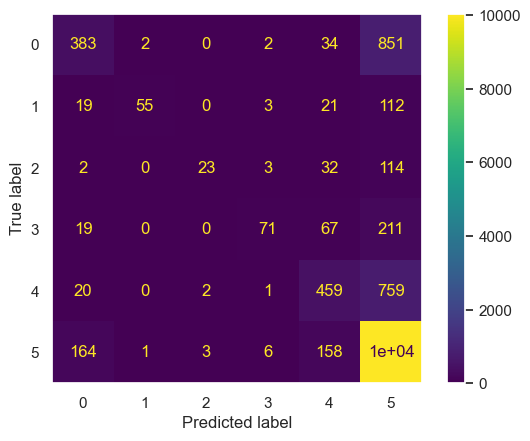

In [52]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=pipeline.classes_)
plt.grid(False)

In [153]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.63      0.22      0.32      1272
           1       0.92      0.80      0.86       210
           2       0.91      0.79      0.85       174
           3       0.73      0.61      0.66       368
           4       0.64      0.24      0.35      1241
           5       0.83      0.97      0.90     10371

    accuracy                           0.82     13636
   macro avg       0.78      0.61      0.66     13636
weighted avg       0.80      0.82      0.79     13636



### Grid Search CV

In [34]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth o

In [31]:
gscv=GridSearchCV(pipeline, {'clsf__splitter': ['random'],
                             'clsf__max_depth': [20, 40, 60],
                             'clsf__min_samples_split': [50, 100, 150],
                             'clsf__min_samples_leaf': [20, 30, 40],
                             'clsf__ccp_alpha': [0.001, 0.005, 0.01],
                             'clsf__class_weight': ['balanced']}, cv=4, n_jobs=-1, error_score=0)
gscv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=0,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value='No_Review',
                                                      strategy='constant')),
                                       ('col_transform',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('pass',
                                                                         'passthrough',
                                                                         ['RecipeNumber',
                                                                          'RecipeCode',
                                                                          'UserReputation',
                                                                          'ReplyCount',
                                                                          'ThumbsUpCount',
                                                                          'ThumbsDownCount',
                                                                          'BestScore',
                                                                          'Hour']),
                                                                        ('day',
                                                                         OneHotEncoder(),
                                                                         ['Da...
                                                            func=<function <lambda> at 0x0000016E24298940>)),
                                       ('scaler', StandardScaler()),
                                       ('pca',
                                        PCA(n_components=0.95,
                                            svd_solver='full')),
                                       ('clsf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clsf__ccp_alpha': [0.001, 0.005, 0.01],
                         'clsf__class_weight': ['balanced'],
                         'clsf__max_depth': [20, 40, 60],
                         'clsf__min_samples_leaf': [20, 30, 40],
                         'clsf__min_samples_split': [50, 100, 150],
                         'clsf__splitter': ['random']})

In [32]:
gscv.best_params_, gscv.best_score_

({'clsf__ccp_alpha': 0.005,
  'clsf__class_weight': 'balanced',
  'clsf__max_depth': 40,
  'clsf__min_samples_leaf': 20,
  'clsf__min_samples_split': 50,
  'clsf__splitter': 'random'},
 0.5055001466705779)

In [33]:
train_predict=gscv.best_estimator_.predict(X_train)
test_predict=gscv.best_estimator_.predict(test_data)

In [34]:
accuracy_score(y_train, train_predict)

0.026987386330302142

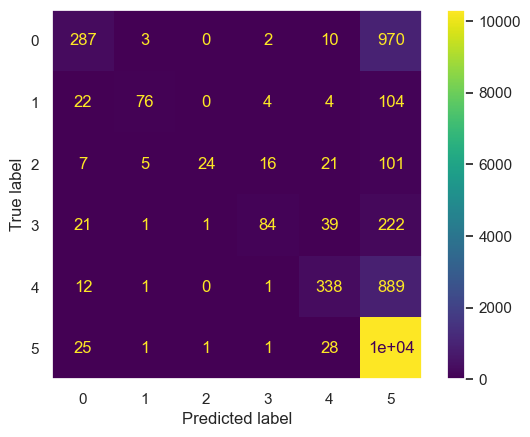

In [145]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=gscv.best_estimator_.classes_)
plt.grid(False)

In [146]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.77      0.23      0.35      1272
           1       0.87      0.36      0.51       210
           2       0.92      0.14      0.24       174
           3       0.78      0.23      0.35       368
           4       0.77      0.27      0.40      1241
           5       0.82      0.99      0.90     10371

    accuracy                           0.82     13636
   macro avg       0.82      0.37      0.46     13636
weighted avg       0.81      0.82      0.77     13636



## Dummy Classifier

In [121]:
dummy=DummyClassifier()
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.7605602816075095

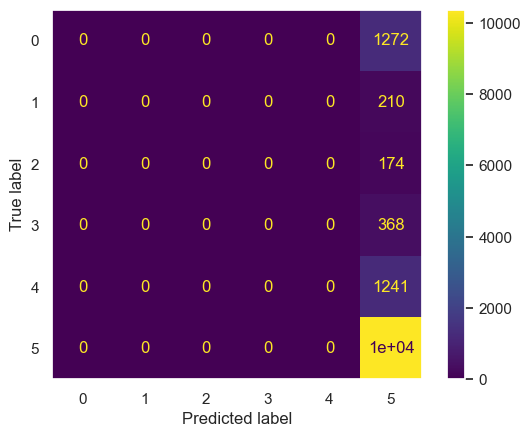

In [127]:
ConfusionMatrixDisplay.from_estimator(dummy, X_train, y_train)
plt.grid(False)

In [130]:
print(classification_report(y_train, dummy.predict(X_train), zero_division=np.nan))

              precision    recall  f1-score   support

           0        nan      0.00       nan      1272
           1        nan      0.00       nan       210
           2        nan      0.00       nan       174
           3        nan      0.00       nan       368
           4        nan      0.00       nan      1241
           5       0.76      1.00      0.86     10371

    accuracy                           0.76     13636
   macro avg       0.76      0.17      0.86     13636
weighted avg       0.76      0.76      0.86     13636

